<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/custom_parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom Parser - Simple

## Installing IceVision and IceData
If on Colab run the following cell, else check the [installation instructions](https://airctic.com/dev/install/)

In [1]:
# IceVision - IceData - MMDetection - YOLO v5 Installation
!wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
!chmod +x install_colab.sh && ./install_colab.sh

## Imports
As always, let's import everything from `icevision`. Additionally, we will also need `pandas` (you might need to install it with `pip install pandas`).

In [11]:
from icevision.all import *
import pandas as pd

## Download dataset

We're going to be using a small sample of the chess dataset, the full dataset is offered by roboflow [here](https://public.roboflow.com/object-detection/chess-full)

In [13]:
data_url = "https://github.com/airctic/chess_sample/archive/master.zip"
data_dir = icedata.load_data(data_url, 'chess_sample') / 'chess_sample-master'

## Understand the data format

In this task we were given a `.csv` file with annotations, let's take a look at that.

!!! danger "Important"  
    Replace `source` with your own path for the dataset directory.

In [14]:
df = pd.read_csv(data_dir / "annotations.csv")
df.head()

,filename,width,height,label,xmin,ymin,xmax,ymax
0,0.jpg,416,416,black-bishop,280,227,310,284
1,0.jpg,416,416,black-king,311,110,345,195
2,0.jpg,416,416,black-queen,237,85,262,159
3,0.jpg,416,416,black-rook,331,277,366,333
4,0.jpg,416,416,black-rook,235,3,255,51


At first glance, we can make the following assumptions:  

  * Multiple rows with the **same** filename, width, height  
  * A **label** for each row
  * A **bbox** [xmin, ymin, xmax, ymax] for each row  
  
Once we know what our data provides we can create our custom `Parser`.  

## Create the Parser

The first step is to create a template record for our specific type of dataset, in this case we're doing standard object detection:

In [15]:
template_record = ObjectDetectionRecord()

Now use the method `generate_template` that will print out all the necessary steps we have to implement.

In [16]:
Parser.generate_template(template_record)

class MyParser(Parser):
    def __init__(self, template_record):
        super().__init__(template_record=template_record)
    def __iter__(self) -> Any:
    def __len__(self) -> int:
    def record_id(self, o) -> Hashable:
    def parse_fields(self, o, record, is_new):
        record.set_filepath(<Union[str, Path]>)
        record.set_img_size(<ImgSize>)
        record.detection.add_bboxes(<Sequence[BBox]>)
        record.detection.set_class_map(<ClassMap>)
        record.detection.add_labels(<Sequence[Hashable]>)


We can copy the template and use it as our starting point. Let's go over each of the methods we have to define:

- `__init__`: What happens here is completely up to you, normally we have to pass some reference to our data, `data_dir` in our case.

- `__iter__`: This tells our parser how to iterate over our data, each item returned here will be passed to `parse_fields` as `o`. In our case we call `df.itertuples` to iterate over all `df` rows.

- `__len__`: How many items will be iterating over.

- `imageid`: Should return a `Hashable` (`int`, `str`, etc). In our case we want all the dataset items that have the same `filename` to be unified in the same record.

- `parse_fields`: Here is where the attributes of the record are collected, the template will suggest what methods we need to call on the record and what parameters it expects. The parameter `o` it receives is the item returned by `__iter__`.

!!! danger "Important"  
    Be sure to pass the correct type on all record methods!

In [17]:
class ChessParser(Parser):
    def __init__(self, template_record, data_dir):
        super().__init__(template_record=template_record)
        
        self.data_dir = data_dir
        self.df = pd.read_csv(data_dir / "annotations.csv")
        self.class_map = ClassMap(list(self.df['label'].unique()))
        
    def __iter__(self) -> Any:
        for o in self.df.itertuples():
            yield o
        
    def __len__(self) -> int:
        return len(self.df)
        
    def record_id(self, o) -> Hashable:
        return o.filename
        
    def parse_fields(self, o, record, is_new):
        if is_new:
            record.set_filepath(self.data_dir / 'images' / o.filename)
            record.set_img_size(ImgSize(width=o.width, height=o.height))
            record.detection.set_class_map(self.class_map)
        
        record.detection.add_bboxes([BBox.from_xyxy(o.xmin, o.ymin, o.xmax, o.ymax)])
        record.detection.add_labels([o.label])

Let's randomly split the data and parser with `Parser.parse`:

In [18]:
parser = ChessParser(template_record, data_dir)

In [20]:
train_records, valid_records = parser.parse()

Let's take a look at one record:

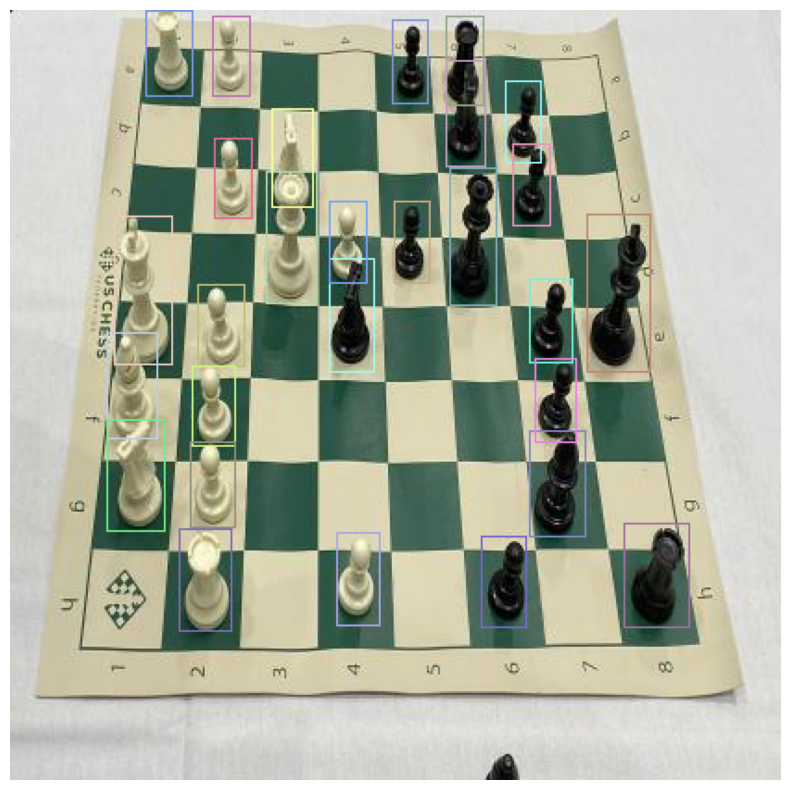

In [21]:
show_record(train_records[0], display_label=False, figsize=(14, 10))

In [22]:
train_records[0]

BaseRecord

common: 
	- Filepath: /home/lgvaz/.icevision/data/chess_sample/chess_sample-master/images/0.jpg
	- Image: None
	- Image ID: 0
	- Image size ImgSize(width=416, height=416)
detection: 
	- BBoxes: [<BBox (xmin:280, ymin:227, xmax:310, ymax:284)>, <BBox (xmin:311, ymin:110, xmax:345, ymax:195)>, <BBox (xmin:237, ymin:85, xmax:262, ymax:159)>, <BBox (xmin:331, ymin:277, xmax:366, ymax:333)>, <BBox (xmin:235, ymin:3, xmax:255, ymax:51)>, <BBox (xmin:267, ymin:38, xmax:286, ymax:82)>, <BBox (xmin:271, ymin:72, xmax:291, ymax:116)>, <BBox (xmin:280, ymin:145, xmax:303, ymax:190)>, <BBox (xmin:283, ymin:188, xmax:305, ymax:233)>, <BBox (xmin:254, ymin:284, xmax:278, ymax:333)>, <BBox (xmin:206, ymin:5, xmax:225, ymax:50)>, <BBox (xmin:207, ymin:103, xmax:226, ymax:147)>, <BBox (xmin:235, ymin:27, xmax:256, ymax:84)>, <BBox (xmin:172, ymin:134, xmax:196, ymax:195)>, <BBox (xmin:138, ymin:87, xmax:165, ymax:158)>, <BBox (xmin:91, ymin:280, xmax:119, ymax:335)>, <BBox (xmin:73, ymin:0,

## Next steps

- This was just merged, come help us adjusting the documentation and fixing the bugs

## Conclusion

And that's it! Now that you have your data in the standard library record format, you can use it to create a `Dataset`, visualize the image with the annotations and basically use all helper functions that IceVision provides! 

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://discord.gg/JDBeZYK).